In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.utils as nn_utils
import math
import scipy
from tqdm import tqdm
from tqdm import trange

device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [3]:
import torch.nn as nn
import os
torch.manual_seed(42)


class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 L=1.0,
                 M=1):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(self.neurons, self.neurons)
            for _ in range(n_hidden_layers - 1)
        ])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()
        self.L = L
        self.M = M

    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        k = torch.arange(1, self.M + 1).to(device)
        out = torch.hstack([
            t.unsqueeze(1).to(device),
            torch.ones((t.shape[0],1)).to(device),
            torch.cos(w* torch.einsum('i,j->ji',k , x).to(device)),
            torch.sin(w* torch.einsum('i,j->ji',k , x).to(device))
        ])
        return out

    def forward(self, x):
        # The forward function performs the set of affine and non-linear
        # transformations defining the network (see equation above)
        x = x.to(device)
        x_encoded = self.input_encoding(x[:,0], x[:,1])
        x_encoded = self.activation(self.input_layer(x_encoded))
        for k, l in enumerate(self.hidden_layers):
            x_encoded = self.activation(l(x_encoded))
        return self.output_layer(x_encoded)

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(
                    m
            ) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

In [4]:
class Pinns_Kuramoto:
    def __init__(self, n_int_t_, n_int_x_, n_sb_, n_tb_, L=1.0, M=1):
        self.n_int_t = n_int_t_
        self.n_int_x = n_int_x_
        self.n_sb = n_sb_
        self.n_tb = n_tb_
        self.tol = 0
        self.lambda_f = 50
        self.W = None
        
        ones_tensor = torch.ones((n_int_t, n_int_t))
        triu_tensor = torch.triu(ones_tensor, diagonal=1)
        self.M = triu_tensor.T.to(device)

        #Set constants
        self.alpha = 5
        self.beta = 0.5
        self.gamma = 0.005

        # Extrema of the solution domain (t,x) in [0,8]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [-1, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1


        # NN to Approximate Solution
        self.approximate_solution_flame = NeuralNet(input_dimension=2*M+2, output_dimension=1,
                                              n_hidden_layers=5,
                                              neurons=120,
                                              regularization_param=0.01,
                                              regularization_exp=2.,
                                              retrain_seed=42,L=2.0, M=1).to(device)
      # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0], scramble = True)
        self.soboleng_int = torch.quasirandom.SobolEngine(dimension=1, scramble = True)

      # Training Sets S_tb, S_sb, S_int as Torch Dataloader
        self.training_set_tb, self.training_set_sb, self.training_set_int, = self.assemble_datasets()

    ################################################################################################

    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    def convert_time(self, tens):
        #assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[0, 1] - self.domain_extrema[0, 0]) + self.domain_extrema[0, 0]

    def convert_space(self, tens):
        #assert (tens.shape[] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[1, 1] - self.domain_extrema[1, 0]) + self.domain_extrema[1, 0]

    def initial_conditions(self, x):
        return -torch.sin(math.pi * x)

    def create_left_sb_mask(self, inp_sb):
        left_sb_mask = (inp_sb[:, 1] == -1)
        return left_sb_mask

    def create_right_sb_mask(self, inp_sb):
        right_sb_mask = (inp_sb[:, 1] == 1)
        return right_sb_mask

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_conditions(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        """
        t0 = self.domain_extrema[0, 0]
        t1 = self.domain_extrema[0, 1]
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]
        
        inpt = torch.linspace(t0 + self.epsilon, t1 - self.epsilon, self.n_int_t)
        inpx = torch.linspace(x0 + self.epsilon, xL - self.epsilon, self.n_int_x)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        """
        
        input_time = self.convert(self.soboleng.draw(self.n_int_t))
        inpt = input_time[:, 0].unique()
        inpx = self.convert_space(self.soboleng_int.draw(self.n_int_x)).squeeze(1)
        tt, xx = torch.meshgrid(inpt, inpx)

        input_int = torch.cat((tt.flatten().unsqueeze(1), xx.flatten().unsqueeze(1)), dim=1)
        output_int = torch.zeros((input_int.shape[0], 1))
        
        return input_int, output_int


    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_int, output_int = self.add_interior_points()  # S_int

        input_tb, output_tb = input_tb.to(device), output_tb.to(device)
        input_sb, output_sb = input_sb.to(device), output_sb.to(device)
        input_int, output_int = input_int.to(device), output_int.to(device)

        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False) #2 * self.space_dimensions * self.n_sb
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int_t * self.n_int_x, shuffle=False)

        return training_set_tb, training_set_sb, training_set_int


################################################################################################

    #   Compute Temporal Boundary Residuals
    def compute_temporal_boundary_residual(self, input_tb, output_tb):
        assert(torch.all(input_tb[:,0] == 0))
        u = self.approximate_solution_flame(input_tb).reshape(-1,)
        temp_tb_train = output_tb.reshape(-1,)

        assert(u.shape == temp_tb_train.shape)
        residual_tb = temp_tb_train - u

        return residual_tb.reshape(-1,)
    """
    #   Compute Spatial Boundary Residuals
    def compute_spatial_boundary_residual(self, input_sb, output_sb):
        u = self.approximate_solution_flame(input_sb).reshape(-1,)

        mask_L = self.create_left_sb_mask(input_sb)
        mask_R = self.create_right_sb_mask(input_sb)
        assert(u[mask_L].shape == u[mask_R].shape)

        residual_sb = u[mask_L] - u[mask_R]

        return residual_sb.reshape(-1,)
    """
    #   Compute Interior Residuals
    def compute_interior_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution_flame(input_int).reshape(-1,)

        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxx = torch.autograd.grad(grad_u_xx.sum(), input_int, create_graph=True)[0][:, 1]
        grad_u_xxxx = torch.autograd.grad(grad_u_xxx.sum(), input_int, create_graph=True)[0][:, 1]

        assert(u.shape == grad_u_t.shape and u.shape == grad_u_x.shape and u.shape == grad_u_xx.shape )

        residual_int = grad_u_t + self.alpha*u*grad_u_x + self.beta*grad_u_xx + self.gamma*grad_u_xxxx
        
        return residual_int.reshape(self.n_int_t,self.n_int_x)


    def compute_loss(self, inp_train_tb, T_train_tb, inp_train_sb, T_train_sb, inp_train_int, T_train_int, verbose=True):
        
        # Temporal Boundary Residuals
        r_tb = self.compute_temporal_boundary_residual(inp_train_tb, T_train_tb)

        # Interior Residuals
        r_int = self.compute_interior_residual(inp_train_int)

        loss_tb = torch.mean(abs(r_tb) ** 2)
        L_t = torch.mean(r_int**2, axis=1)
        self.W = torch.exp(- self.tol * torch.matmul(self.M, L_t)).detach().to(device)
        loss_int = torch.mean(self.W * L_t)

        loss = torch.log10(self.lambda_f * loss_tb  + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4), "| Temporal Loss: ", round(torch.log10(loss_tb).item(), 4))

        return loss
    
    ################################################################################################
    
    
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()
        
        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_tb, u_train_tb), (inp_train_sb, u_train_sb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_tb, self.training_set_sb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_tb, u_train_tb, inp_train_sb, u_train_sb, inp_train_int, u_train_int, verbose=True)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history


In [5]:
n_int_t = 64
n_int_x = 128
n_sb = 512
n_tb = 1024
pinn_k = Pinns_Kuramoto(n_int_t, n_int_x, n_sb, n_tb)

C:\Users\matth\AppData\Roaming\Python\Python310\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


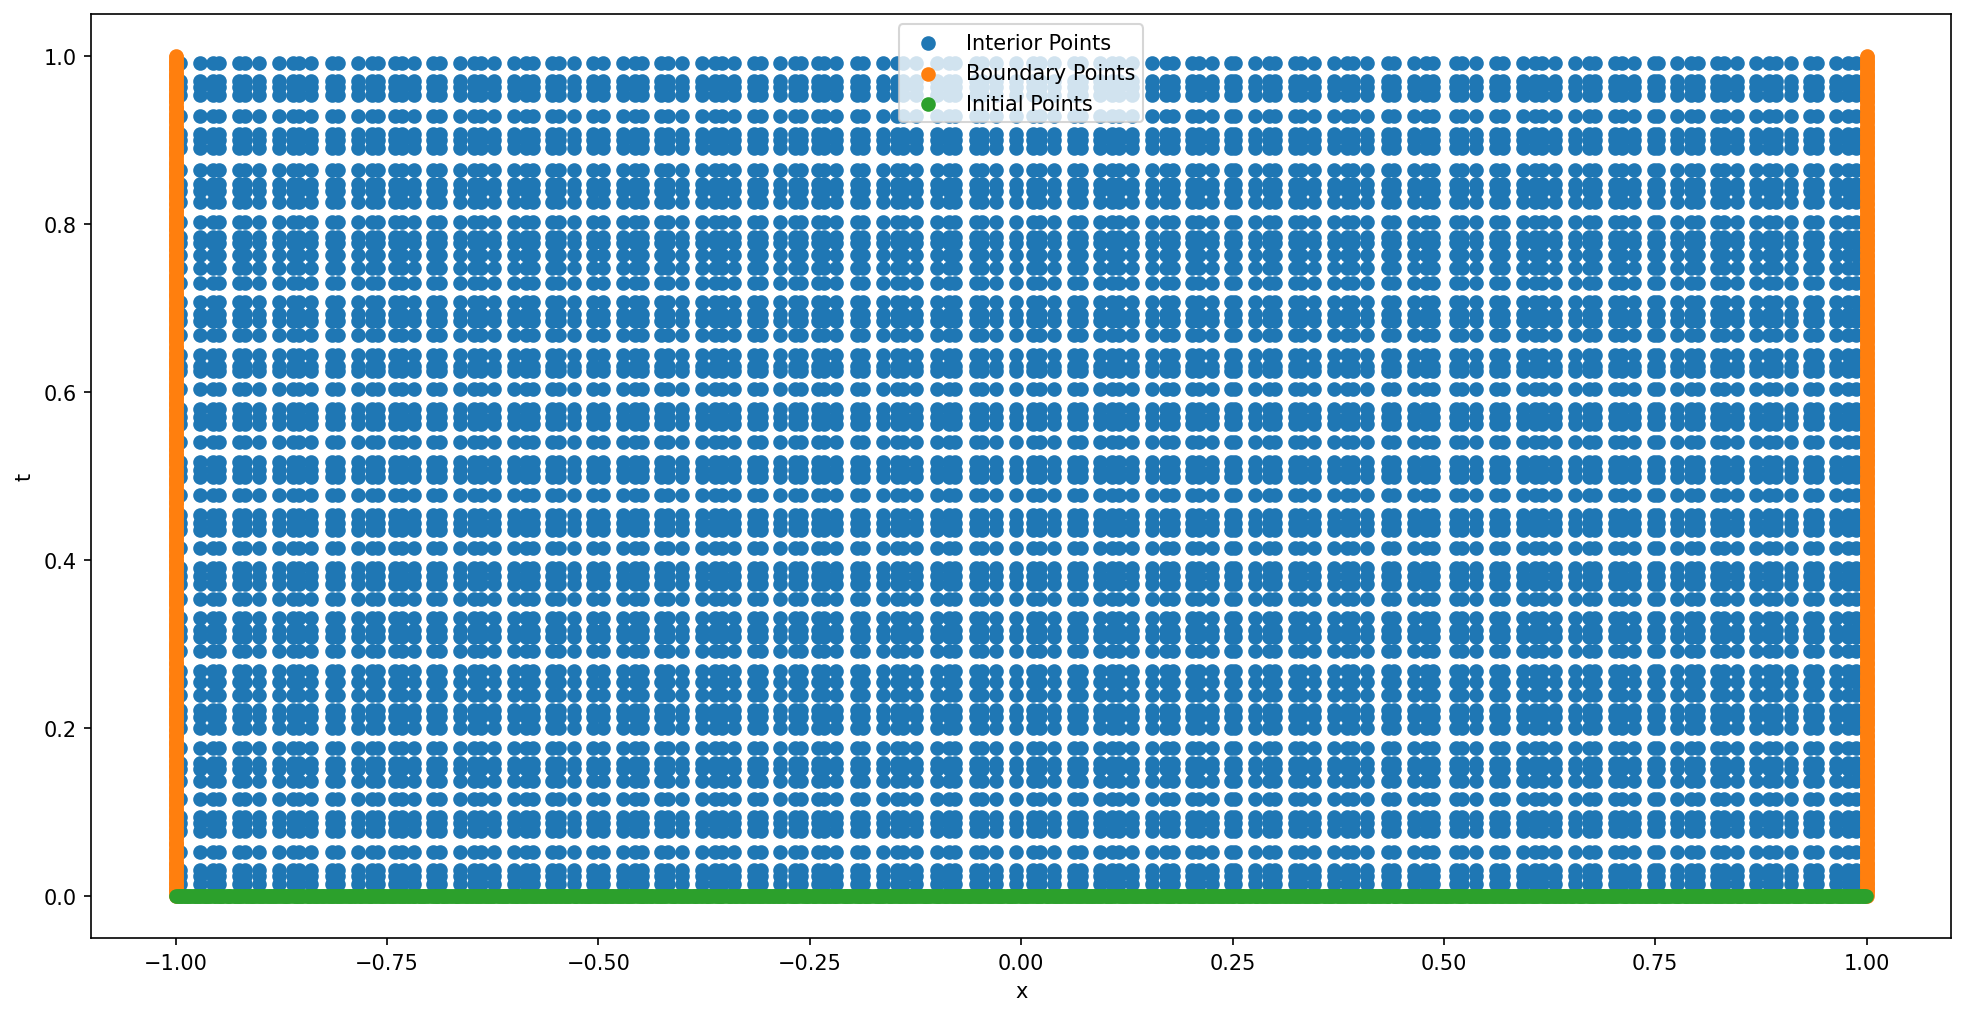

In [6]:
# Plot the input training points
input_tb_, output_tb_ = pinn_k.add_temporal_boundary_points()
input_sb_, output_sb_ = pinn_k.add_spatial_boundary_points()
input_int_, output_int_ = pinn_k.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()


In [7]:
optimizer_LBFGS = optim.LBFGS(list(pinn_k.approximate_solution_flame.parameters()),
                              lr=float(0.5),
                              max_iter=20000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=-1)

In [8]:
n_epochs = 1 
hist = pinn_k.fit(num_epochs=n_epochs,
              optimizer=optimizer_LBFGS,
              verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

################################  0  ################################
Total loss:  2.6019 | PDE Loss:  2.4801 | Temporal Loss:  0.2913
Total loss:  2.5746 | PDE Loss:  2.4491 | Temporal Loss:  0.2754
Total loss:  2.3293 | PDE Loss:  2.1686 | Temporal Loss:  0.1206
Total loss:  1.8923 | PDE Loss:  1.7944 | Temporal Loss:  -0.5017
Total loss:  1.6881 | PDE Loss:  1.6293 | Temporal Loss:  -0.908
Total loss:  1.4597 | PDE Loss:  1.4195 | Temporal Loss:  -1.2929
Total loss:  1.3179 | PDE Loss:  1.1967 | Temporal Loss:  -0.9944
Total loss:  1.198 | PDE Loss:  0.9708 | Temporal Loss:  -0.891
Total loss:  1.1239 | PDE Loss:  0.8506 | Temporal Loss:  -0.9057
Total loss:  1.0144 | PDE Loss:  0.7524 | Temporal Loss:  -1.0285
Total loss:  0.9267 | PDE Loss:  0.7048 | Temporal Loss:  -1.1701
Total loss:  0.8783 | PDE Loss:  0.7458 | Temporal Loss:  -1.4008
Total loss:  0.8491 | PDE Loss:  0.7188 | Temporal Loss:  -1.4363
Total loss:  0.8183 | PDE Loss:  0.6875 | Temporal Loss:  -1.4659
Total loss: 

Total loss:  0.6192 | PDE Loss:  0.5216 | Temporal Loss:  -1.7758
Total loss:  0.619 | PDE Loss:  0.5217 | Temporal Loss:  -1.7776
Total loss:  0.6188 | PDE Loss:  0.5215 | Temporal Loss:  -1.7778
Total loss:  0.6186 | PDE Loss:  0.5218 | Temporal Loss:  -1.7796
Total loss:  0.6184 | PDE Loss:  0.5219 | Temporal Loss:  -1.7815
Total loss:  0.6181 | PDE Loss:  0.5223 | Temporal Loss:  -1.7844
Total loss:  0.6179 | PDE Loss:  0.5221 | Temporal Loss:  -1.7843
Total loss:  0.6178 | PDE Loss:  0.5228 | Temporal Loss:  -1.788
Total loss:  0.6176 | PDE Loss:  0.5224 | Temporal Loss:  -1.787
Total loss:  0.6174 | PDE Loss:  0.5226 | Temporal Loss:  -1.7889
Total loss:  0.617 | PDE Loss:  0.5213 | Temporal Loss:  -1.7858
Total loss:  0.6165 | PDE Loss:  0.5229 | Temporal Loss:  -1.7948
Total loss:  0.6161 | PDE Loss:  0.5206 | Temporal Loss:  -1.7875
Total loss:  0.6158 | PDE Loss:  0.5215 | Temporal Loss:  -1.7928
Total loss:  0.6156 | PDE Loss:  0.5214 | Temporal Loss:  -1.7935
Total loss:  0

Total loss:  0.4108 | PDE Loss:  0.3966 | Temporal Loss:  -2.7828
Total loss:  0.4092 | PDE Loss:  0.3951 | Temporal Loss:  -2.786
Total loss:  0.4078 | PDE Loss:  0.3942 | Temporal Loss:  -2.8018
Total loss:  0.4067 | PDE Loss:  0.3932 | Temporal Loss:  -2.8067
Total loss:  0.4058 | PDE Loss:  0.3923 | Temporal Loss:  -2.8077
Total loss:  0.4049 | PDE Loss:  0.3911 | Temporal Loss:  -2.7997
Total loss:  0.4041 | PDE Loss:  0.3904 | Temporal Loss:  -2.8015
Total loss:  0.4032 | PDE Loss:  0.3892 | Temporal Loss:  -2.7951
Total loss:  0.4021 | PDE Loss:  0.3881 | Temporal Loss:  -2.7954
Total loss:  0.401 | PDE Loss:  0.387 | Temporal Loss:  -2.7957
Total loss:  0.4003 | PDE Loss:  0.3862 | Temporal Loss:  -2.7962
Total loss:  0.3995 | PDE Loss:  0.3856 | Temporal Loss:  -2.7998
Total loss:  0.3988 | PDE Loss:  0.3849 | Temporal Loss:  -2.8018
Total loss:  0.3982 | PDE Loss:  0.3844 | Temporal Loss:  -2.8057
Total loss:  0.3976 | PDE Loss:  0.3839 | Temporal Loss:  -2.8069
Total loss:  

Total loss:  0.3423 | PDE Loss:  0.3358 | Temporal Loss:  -3.1815
Total loss:  0.3417 | PDE Loss:  0.3354 | Temporal Loss:  -3.1965
Total loss:  0.3408 | PDE Loss:  0.3344 | Temporal Loss:  -3.1944
Total loss:  0.3395 | PDE Loss:  0.3332 | Temporal Loss:  -3.1989
Total loss:  0.3383 | PDE Loss:  0.3319 | Temporal Loss:  -3.1965
Total loss:  0.3371 | PDE Loss:  0.3301 | Temporal Loss:  -3.1555
Total loss:  0.3361 | PDE Loss:  0.3289 | Temporal Loss:  -3.1477
Total loss:  0.3354 | PDE Loss:  0.3282 | Temporal Loss:  -3.1476
Total loss:  0.3349 | PDE Loss:  0.3276 | Temporal Loss:  -3.1411
Total loss:  0.3343 | PDE Loss:  0.3267 | Temporal Loss:  -3.1251
Total loss:  0.3338 | PDE Loss:  0.3262 | Temporal Loss:  -3.1258
Total loss:  0.3333 | PDE Loss:  0.3257 | Temporal Loss:  -3.1306
Total loss:  0.3325 | PDE Loss:  0.3248 | Temporal Loss:  -3.124
Total loss:  0.3316 | PDE Loss:  0.3243 | Temporal Loss:  -3.1415
Total loss:  0.3304 | PDE Loss:  0.3232 | Temporal Loss:  -3.1515
Total loss:

Total loss:  -0.2164 | PDE Loss:  -0.2948 | Temporal Loss:  -2.6975
Total loss:  -0.2177 | PDE Loss:  -0.2964 | Temporal Loss:  -2.697
Total loss:  -0.219 | PDE Loss:  -0.298 | Temporal Loss:  -2.6967
Total loss:  -0.2205 | PDE Loss:  -0.2998 | Temporal Loss:  -2.6973
Total loss:  -0.2225 | PDE Loss:  -0.303 | Temporal Loss:  -2.6928
Total loss:  -0.2245 | PDE Loss:  -0.3053 | Temporal Loss:  -2.6936
Total loss:  -0.2272 | PDE Loss:  -0.3083 | Temporal Loss:  -2.6945
Total loss:  -0.2304 | PDE Loss:  -0.3113 | Temporal Loss:  -2.6987
Total loss:  -0.2337 | PDE Loss:  -0.3141 | Temporal Loss:  -2.7048
Total loss:  -0.2371 | PDE Loss:  -0.3164 | Temporal Loss:  -2.7137
Total loss:  -0.2406 | PDE Loss:  -0.32 | Temporal Loss:  -2.7167
Total loss:  -0.2433 | PDE Loss:  -0.3221 | Temporal Loss:  -2.7227
Total loss:  -0.2453 | PDE Loss:  -0.3243 | Temporal Loss:  -2.723
Total loss:  -0.2467 | PDE Loss:  -0.3265 | Temporal Loss:  -2.7208
Total loss:  -0.2482 | PDE Loss:  -0.3287 | Temporal Lo

Total loss:  -0.4184 | PDE Loss:  -0.4647 | Temporal Loss:  -3.1127
Total loss:  -0.4189 | PDE Loss:  -0.4648 | Temporal Loss:  -3.1168
Total loss:  -0.4197 | PDE Loss:  -0.4652 | Temporal Loss:  -3.1209
Total loss:  -0.4203 | PDE Loss:  -0.4654 | Temporal Loss:  -3.1248
Total loss:  -0.421 | PDE Loss:  -0.4657 | Temporal Loss:  -3.1297
Total loss:  -0.4217 | PDE Loss:  -0.4661 | Temporal Loss:  -3.1331
Total loss:  -0.4224 | PDE Loss:  -0.4665 | Temporal Loss:  -3.1364
Total loss:  -0.4233 | PDE Loss:  -0.4675 | Temporal Loss:  -3.136
Total loss:  -0.4242 | PDE Loss:  -0.4684 | Temporal Loss:  -3.1381
Total loss:  -0.4251 | PDE Loss:  -0.4696 | Temporal Loss:  -3.1348
Total loss:  -0.4258 | PDE Loss:  -0.4707 | Temporal Loss:  -3.1329
Total loss:  -0.4265 | PDE Loss:  -0.4719 | Temporal Loss:  -3.1289
Total loss:  -0.4271 | PDE Loss:  -0.4726 | Temporal Loss:  -3.1279
Total loss:  -0.4276 | PDE Loss:  -0.4734 | Temporal Loss:  -3.1261
Total loss:  -0.4282 | PDE Loss:  -0.4737 | Tempor

Total loss:  -0.4752 | PDE Loss:  -0.5103 | Temporal Loss:  -3.2847
Total loss:  -0.4756 | PDE Loss:  -0.5102 | Temporal Loss:  -3.2906
Total loss:  -0.4759 | PDE Loss:  -0.5101 | Temporal Loss:  -3.2951
Total loss:  -0.4762 | PDE Loss:  -0.5101 | Temporal Loss:  -3.3003
Total loss:  -0.4766 | PDE Loss:  -0.5101 | Temporal Loss:  -3.3039
Total loss:  -0.4769 | PDE Loss:  -0.5102 | Temporal Loss:  -3.3083
Total loss:  -0.4772 | PDE Loss:  -0.5106 | Temporal Loss:  -3.307
Total loss:  -0.4775 | PDE Loss:  -0.5108 | Temporal Loss:  -3.308
Total loss:  -0.4777 | PDE Loss:  -0.5111 | Temporal Loss:  -3.3073
Total loss:  -0.4779 | PDE Loss:  -0.5115 | Temporal Loss:  -3.3055
Total loss:  -0.4781 | PDE Loss:  -0.5118 | Temporal Loss:  -3.3031
Total loss:  -0.4782 | PDE Loss:  -0.5122 | Temporal Loss:  -3.3006
Total loss:  -0.4783 | PDE Loss:  -0.5125 | Temporal Loss:  -3.2984
Total loss:  -0.4785 | PDE Loss:  -0.5129 | Temporal Loss:  -3.2962
Total loss:  -0.4788 | PDE Loss:  -0.5136 | Tempor

Total loss:  -0.495 | PDE Loss:  -0.5314 | Temporal Loss:  -3.2887
Total loss:  -0.4951 | PDE Loss:  -0.5315 | Temporal Loss:  -3.2893
Total loss:  -0.4952 | PDE Loss:  -0.5315 | Temporal Loss:  -3.29
Total loss:  -0.4953 | PDE Loss:  -0.5314 | Temporal Loss:  -3.2915
Total loss:  -0.4954 | PDE Loss:  -0.5316 | Temporal Loss:  -3.2913
Total loss:  -0.4955 | PDE Loss:  -0.5317 | Temporal Loss:  -3.2918
Total loss:  -0.4957 | PDE Loss:  -0.5319 | Temporal Loss:  -3.2917
Total loss:  -0.4957 | PDE Loss:  -0.5319 | Temporal Loss:  -3.2923
Total loss:  -0.4958 | PDE Loss:  -0.5319 | Temporal Loss:  -3.2929
Total loss:  -0.4958 | PDE Loss:  -0.5319 | Temporal Loss:  -3.2939
Total loss:  -0.4959 | PDE Loss:  -0.5318 | Temporal Loss:  -3.2955
Total loss:  -0.496 | PDE Loss:  -0.5317 | Temporal Loss:  -3.2973
Total loss:  -0.4961 | PDE Loss:  -0.5316 | Temporal Loss:  -3.2996
Total loss:  -0.4961 | PDE Loss:  -0.5316 | Temporal Loss:  -3.3005
Total loss:  -0.4962 | PDE Loss:  -0.5317 | Temporal

Total loss:  -0.5072 | PDE Loss:  -0.5462 | Temporal Loss:  -3.2717
Total loss:  -0.5073 | PDE Loss:  -0.5464 | Temporal Loss:  -3.2712
Total loss:  -0.5074 | PDE Loss:  -0.5464 | Temporal Loss:  -3.2727
Total loss:  -0.5075 | PDE Loss:  -0.5464 | Temporal Loss:  -3.2734
Total loss:  -0.5075 | PDE Loss:  -0.5464 | Temporal Loss:  -3.2735
Total loss:  -0.5076 | PDE Loss:  -0.5466 | Temporal Loss:  -3.273
Total loss:  -0.5076 | PDE Loss:  -0.5467 | Temporal Loss:  -3.2721
Total loss:  -0.5077 | PDE Loss:  -0.5469 | Temporal Loss:  -3.2708
Total loss:  -0.5077 | PDE Loss:  -0.5471 | Temporal Loss:  -3.2692
Total loss:  -0.5078 | PDE Loss:  -0.5474 | Temporal Loss:  -3.2672
Total loss:  -0.5079 | PDE Loss:  -0.5477 | Temporal Loss:  -3.2647
Total loss:  -0.508 | PDE Loss:  -0.5479 | Temporal Loss:  -3.2634
Total loss:  -0.5081 | PDE Loss:  -0.5481 | Temporal Loss:  -3.2624
Total loss:  -0.5081 | PDE Loss:  -0.5482 | Temporal Loss:  -3.2617
Total loss:  -0.5082 | PDE Loss:  -0.5483 | Tempor

Total loss:  -0.5161 | PDE Loss:  -0.5536 | Temporal Loss:  -3.2977
Total loss:  -0.5162 | PDE Loss:  -0.5535 | Temporal Loss:  -3.2993
Total loss:  -0.5162 | PDE Loss:  -0.5535 | Temporal Loss:  -3.3001
Total loss:  -0.5163 | PDE Loss:  -0.5535 | Temporal Loss:  -3.3011
Total loss:  -0.5163 | PDE Loss:  -0.5534 | Temporal Loss:  -3.302
Total loss:  -0.5164 | PDE Loss:  -0.5534 | Temporal Loss:  -3.3026
Total loss:  -0.5164 | PDE Loss:  -0.5534 | Temporal Loss:  -3.3038
Total loss:  -0.5165 | PDE Loss:  -0.5535 | Temporal Loss:  -3.3034
Total loss:  -0.5166 | PDE Loss:  -0.5535 | Temporal Loss:  -3.304
Total loss:  -0.5166 | PDE Loss:  -0.5536 | Temporal Loss:  -3.3035
Total loss:  -0.5167 | PDE Loss:  -0.5538 | Temporal Loss:  -3.3032
Total loss:  -0.5168 | PDE Loss:  -0.5539 | Temporal Loss:  -3.303
Total loss:  -0.5169 | PDE Loss:  -0.554 | Temporal Loss:  -3.3031
Total loss:  -0.517 | PDE Loss:  -0.5541 | Temporal Loss:  -3.3033
Total loss:  -0.5171 | PDE Loss:  -0.5541 | Temporal 

Total loss:  -0.5234 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2761
Total loss:  -0.5235 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2764
Total loss:  -0.5235 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2773
Total loss:  -0.5235 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2772
Total loss:  -0.5236 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2777
Total loss:  -0.5236 | PDE Loss:  -0.5637 | Temporal Loss:  -3.2778
Total loss:  -0.5237 | PDE Loss:  -0.5637 | Temporal Loss:  -3.2785
Total loss:  -0.5238 | PDE Loss:  -0.5637 | Temporal Loss:  -3.279
Total loss:  -0.5238 | PDE Loss:  -0.5637 | Temporal Loss:  -3.2797
Total loss:  -0.5239 | PDE Loss:  -0.5637 | Temporal Loss:  -3.281
Total loss:  -0.524 | PDE Loss:  -0.5636 | Temporal Loss:  -3.2828
Total loss:  -0.5241 | PDE Loss:  -0.5635 | Temporal Loss:  -3.2851
Total loss:  -0.5242 | PDE Loss:  -0.5634 | Temporal Loss:  -3.2869
Total loss:  -0.5242 | PDE Loss:  -0.5633 | Temporal Loss:  -3.2883
Total loss:  -0.5243 | PDE Loss:  -0.5633 | Tempora

Total loss:  -0.53 | PDE Loss:  -0.5691 | Temporal Loss:  -3.2939
Total loss:  -0.5301 | PDE Loss:  -0.5692 | Temporal Loss:  -3.2943
Total loss:  -0.5302 | PDE Loss:  -0.5691 | Temporal Loss:  -3.2954
Total loss:  -0.5302 | PDE Loss:  -0.5692 | Temporal Loss:  -3.2948
Total loss:  -0.5302 | PDE Loss:  -0.5693 | Temporal Loss:  -3.2947
Total loss:  -0.5303 | PDE Loss:  -0.5694 | Temporal Loss:  -3.294
Total loss:  -0.5303 | PDE Loss:  -0.5695 | Temporal Loss:  -3.2934
Total loss:  -0.5304 | PDE Loss:  -0.5697 | Temporal Loss:  -3.2923
Total loss:  -0.5305 | PDE Loss:  -0.5698 | Temporal Loss:  -3.2917
Total loss:  -0.5305 | PDE Loss:  -0.57 | Temporal Loss:  -3.2904
Total loss:  -0.5306 | PDE Loss:  -0.5701 | Temporal Loss:  -3.2897
Total loss:  -0.5306 | PDE Loss:  -0.5703 | Temporal Loss:  -3.2888
Total loss:  -0.5307 | PDE Loss:  -0.5704 | Temporal Loss:  -3.2883
Total loss:  -0.5308 | PDE Loss:  -0.5705 | Temporal Loss:  -3.2879
Total loss:  -0.5308 | PDE Loss:  -0.5706 | Temporal 

Total loss:  -0.5365 | PDE Loss:  -0.5759 | Temporal Loss:  -3.298
Total loss:  -0.5365 | PDE Loss:  -0.5759 | Temporal Loss:  -3.2974
Total loss:  -0.5366 | PDE Loss:  -0.576 | Temporal Loss:  -3.2973
Total loss:  -0.5366 | PDE Loss:  -0.576 | Temporal Loss:  -3.2974
Total loss:  -0.5367 | PDE Loss:  -0.576 | Temporal Loss:  -3.2979
Total loss:  -0.5367 | PDE Loss:  -0.5761 | Temporal Loss:  -3.2982
Total loss:  -0.5368 | PDE Loss:  -0.576 | Temporal Loss:  -3.299
Total loss:  -0.5368 | PDE Loss:  -0.576 | Temporal Loss:  -3.2993
Total loss:  -0.5368 | PDE Loss:  -0.576 | Temporal Loss:  -3.2998
Total loss:  -0.5369 | PDE Loss:  -0.5761 | Temporal Loss:  -3.2997
Total loss:  -0.5369 | PDE Loss:  -0.5761 | Temporal Loss:  -3.2998
Total loss:  -0.537 | PDE Loss:  -0.5762 | Temporal Loss:  -3.2996
Total loss:  -0.537 | PDE Loss:  -0.5761 | Temporal Loss:  -3.3013
Total loss:  -0.5371 | PDE Loss:  -0.5762 | Temporal Loss:  -3.3007
Total loss:  -0.5371 | PDE Loss:  -0.5763 | Temporal Loss:

Total loss:  -0.5418 | PDE Loss:  -0.5784 | Temporal Loss:  -3.3338
Total loss:  -0.5419 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3321
Total loss:  -0.5419 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3326
Total loss:  -0.542 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3328
Total loss:  -0.542 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3334
Total loss:  -0.5421 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3338
Total loss:  -0.5421 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3344
Total loss:  -0.5422 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3348
Total loss:  -0.5422 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3354
Total loss:  -0.5422 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3359
Total loss:  -0.5422 | PDE Loss:  -0.5786 | Temporal Loss:  -3.3364
Total loss:  -0.5423 | PDE Loss:  -0.5786 | Temporal Loss:  -3.337
Total loss:  -0.5423 | PDE Loss:  -0.5785 | Temporal Loss:  -3.3379
Total loss:  -0.5423 | PDE Loss:  -0.5785 | Temporal Loss:  -3.3387
Total loss:  -0.5423 | PDE Loss:  -0.5785 | Tempora

Total loss:  -0.5475 | PDE Loss:  -0.5825 | Temporal Loss:  -3.3572
Total loss:  -0.5475 | PDE Loss:  -0.5825 | Temporal Loss:  -3.3575
Total loss:  -0.5476 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3576
Total loss:  -0.5476 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3581
Total loss:  -0.5477 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3585
Total loss:  -0.5478 | PDE Loss:  -0.5825 | Temporal Loss:  -3.3606
Total loss:  -0.5478 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3611
Total loss:  -0.5479 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3618
Total loss:  -0.548 | PDE Loss:  -0.5826 | Temporal Loss:  -3.3623
Total loss:  -0.5481 | PDE Loss:  -0.5826 | Temporal Loss:  -3.363
Total loss:  -0.5481 | PDE Loss:  -0.5827 | Temporal Loss:  -3.3632
Total loss:  -0.5482 | PDE Loss:  -0.5827 | Temporal Loss:  -3.3635
Total loss:  -0.5482 | PDE Loss:  -0.5828 | Temporal Loss:  -3.363
Total loss:  -0.5483 | PDE Loss:  -0.5829 | Temporal Loss:  -3.3638
Total loss:  -0.5484 | PDE Loss:  -0.5831 | Tempora

Total loss:  -0.553 | PDE Loss:  -0.5865 | Temporal Loss:  -3.3807
Total loss:  -0.553 | PDE Loss:  -0.5866 | Temporal Loss:  -3.3803
Total loss:  -0.553 | PDE Loss:  -0.5867 | Temporal Loss:  -3.3796
Total loss:  -0.5531 | PDE Loss:  -0.5868 | Temporal Loss:  -3.3791
Total loss:  -0.5532 | PDE Loss:  -0.5869 | Temporal Loss:  -3.3785
Total loss:  -0.5532 | PDE Loss:  -0.587 | Temporal Loss:  -3.3788
Total loss:  -0.5533 | PDE Loss:  -0.587 | Temporal Loss:  -3.3792
Total loss:  -0.5533 | PDE Loss:  -0.587 | Temporal Loss:  -3.3795
Total loss:  -0.5534 | PDE Loss:  -0.587 | Temporal Loss:  -3.3803
Total loss:  -0.5534 | PDE Loss:  -0.587 | Temporal Loss:  -3.3805
Total loss:  -0.5534 | PDE Loss:  -0.5871 | Temporal Loss:  -3.3803
Total loss:  -0.5535 | PDE Loss:  -0.5871 | Temporal Loss:  -3.3806
Total loss:  -0.5535 | PDE Loss:  -0.5871 | Temporal Loss:  -3.3807
Total loss:  -0.5535 | PDE Loss:  -0.5871 | Temporal Loss:  -3.3806
Total loss:  -0.5535 | PDE Loss:  -0.5872 | Temporal Los

Total loss:  -0.5575 | PDE Loss:  -0.5925 | Temporal Loss:  -3.3672
Total loss:  -0.5575 | PDE Loss:  -0.5925 | Temporal Loss:  -3.3674
Total loss:  -0.5575 | PDE Loss:  -0.5926 | Temporal Loss:  -3.3664
Total loss:  -0.5575 | PDE Loss:  -0.5928 | Temporal Loss:  -3.365
Total loss:  -0.5576 | PDE Loss:  -0.5929 | Temporal Loss:  -3.3634
Total loss:  -0.5576 | PDE Loss:  -0.5931 | Temporal Loss:  -3.3622
Total loss:  -0.5576 | PDE Loss:  -0.5932 | Temporal Loss:  -3.3613
Total loss:  -0.5577 | PDE Loss:  -0.5932 | Temporal Loss:  -3.361
Total loss:  -0.5577 | PDE Loss:  -0.5935 | Temporal Loss:  -3.3591
Total loss:  -0.5578 | PDE Loss:  -0.5933 | Temporal Loss:  -3.3612
Total loss:  -0.5578 | PDE Loss:  -0.5934 | Temporal Loss:  -3.361
Total loss:  -0.5578 | PDE Loss:  -0.5934 | Temporal Loss:  -3.3615
Total loss:  -0.5578 | PDE Loss:  -0.5933 | Temporal Loss:  -3.362
Total loss:  -0.5579 | PDE Loss:  -0.5934 | Temporal Loss:  -3.362
Total loss:  -0.5579 | PDE Loss:  -0.5934 | Temporal 

Total loss:  -0.5617 | PDE Loss:  -0.596 | Temporal Loss:  -3.3796
Total loss:  -0.5617 | PDE Loss:  -0.596 | Temporal Loss:  -3.38
Total loss:  -0.5617 | PDE Loss:  -0.596 | Temporal Loss:  -3.38
Total loss:  -0.5618 | PDE Loss:  -0.5961 | Temporal Loss:  -3.3798
Total loss:  -0.5618 | PDE Loss:  -0.5962 | Temporal Loss:  -3.3792
Total loss:  -0.5618 | PDE Loss:  -0.5963 | Temporal Loss:  -3.3781
Total loss:  -0.5618 | PDE Loss:  -0.5964 | Temporal Loss:  -3.3767
Total loss:  -0.5619 | PDE Loss:  -0.5967 | Temporal Loss:  -3.3741
Total loss:  -0.562 | PDE Loss:  -0.597 | Temporal Loss:  -3.3721
Total loss:  -0.562 | PDE Loss:  -0.5971 | Temporal Loss:  -3.3708
Total loss:  -0.562 | PDE Loss:  -0.5972 | Temporal Loss:  -3.3704
Total loss:  -0.5621 | PDE Loss:  -0.5972 | Temporal Loss:  -3.3707
Total loss:  -0.5621 | PDE Loss:  -0.5971 | Temporal Loss:  -3.3724
Total loss:  -0.5621 | PDE Loss:  -0.597 | Temporal Loss:  -3.3735
Total loss:  -0.5621 | PDE Loss:  -0.5968 | Temporal Loss:  

Total loss:  -0.5655 | PDE Loss:  -0.6009 | Temporal Loss:  -3.3705
Total loss:  -0.5655 | PDE Loss:  -0.601 | Temporal Loss:  -3.37
Total loss:  -0.5655 | PDE Loss:  -0.6011 | Temporal Loss:  -3.3691
Total loss:  -0.5655 | PDE Loss:  -0.601 | Temporal Loss:  -3.3696
Total loss:  -0.5656 | PDE Loss:  -0.6011 | Temporal Loss:  -3.3693
Total loss:  -0.5656 | PDE Loss:  -0.601 | Temporal Loss:  -3.3708
Total loss:  -0.5656 | PDE Loss:  -0.601 | Temporal Loss:  -3.3716
Total loss:  -0.5657 | PDE Loss:  -0.6009 | Temporal Loss:  -3.373
Total loss:  -0.5657 | PDE Loss:  -0.6008 | Temporal Loss:  -3.375
Total loss:  -0.5657 | PDE Loss:  -0.6007 | Temporal Loss:  -3.3765
Total loss:  -0.5658 | PDE Loss:  -0.6006 | Temporal Loss:  -3.3783
Total loss:  -0.5658 | PDE Loss:  -0.6005 | Temporal Loss:  -3.3795
Total loss:  -0.5658 | PDE Loss:  -0.6004 | Temporal Loss:  -3.3811
Total loss:  -0.5659 | PDE Loss:  -0.6003 | Temporal Loss:  -3.3828
Total loss:  -0.5659 | PDE Loss:  -0.6002 | Temporal Los

Total loss:  -0.5689 | PDE Loss:  -0.6049 | Temporal Loss:  -3.3681
Total loss:  -0.569 | PDE Loss:  -0.6049 | Temporal Loss:  -3.3685
Total loss:  -0.569 | PDE Loss:  -0.6048 | Temporal Loss:  -3.3693
Total loss:  -0.569 | PDE Loss:  -0.6048 | Temporal Loss:  -3.37
Total loss:  -0.569 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3709
Total loss:  -0.5691 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3715
Total loss:  -0.5691 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3721
Total loss:  -0.5691 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3723
Total loss:  -0.5692 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3728
Total loss:  -0.5692 | PDE Loss:  -0.6047 | Temporal Loss:  -3.3728
Total loss:  -0.5692 | PDE Loss:  -0.6048 | Temporal Loss:  -3.3726
Total loss:  -0.5692 | PDE Loss:  -0.6048 | Temporal Loss:  -3.3725
Total loss:  -0.5692 | PDE Loss:  -0.6048 | Temporal Loss:  -3.3724
Total loss:  -0.5693 | PDE Loss:  -0.6048 | Temporal Loss:  -3.3726
Total loss:  -0.5693 | PDE Loss:  -0.6049 | Temporal L

Total loss:  -0.5723 | PDE Loss:  -0.6066 | Temporal Loss:  -3.3907
Total loss:  -0.5723 | PDE Loss:  -0.6067 | Temporal Loss:  -3.3907
Total loss:  -0.5724 | PDE Loss:  -0.6067 | Temporal Loss:  -3.3905
Total loss:  -0.5724 | PDE Loss:  -0.6067 | Temporal Loss:  -3.3907
Total loss:  -0.5724 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3906
Total loss:  -0.5725 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3907
Total loss:  -0.5725 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3906
Total loss:  -0.5725 | PDE Loss:  -0.6068 | Temporal Loss:  -3.391
Total loss:  -0.5725 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3912
Total loss:  -0.5726 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3916
Total loss:  -0.5726 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3925
Total loss:  -0.5726 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3925
Total loss:  -0.5727 | PDE Loss:  -0.6068 | Temporal Loss:  -3.3933
Total loss:  -0.5727 | PDE Loss:  -0.6068 | Temporal Loss:  -3.394
Total loss:  -0.5727 | PDE Loss:  -0.6068 | Tempor

Total loss:  -0.5752 | PDE Loss:  -0.6101 | Temporal Loss:  -3.3854
Total loss:  -0.5752 | PDE Loss:  -0.6101 | Temporal Loss:  -3.3862
Total loss:  -0.5752 | PDE Loss:  -0.61 | Temporal Loss:  -3.3875
Total loss:  -0.5753 | PDE Loss:  -0.61 | Temporal Loss:  -3.3887
Total loss:  -0.5753 | PDE Loss:  -0.6099 | Temporal Loss:  -3.3896
Total loss:  -0.5753 | PDE Loss:  -0.6099 | Temporal Loss:  -3.3903
Total loss:  -0.5754 | PDE Loss:  -0.6099 | Temporal Loss:  -3.3913
Total loss:  -0.5754 | PDE Loss:  -0.6099 | Temporal Loss:  -3.3913
Total loss:  -0.5754 | PDE Loss:  -0.61 | Temporal Loss:  -3.3913
Total loss:  -0.5755 | PDE Loss:  -0.61 | Temporal Loss:  -3.391
Total loss:  -0.5755 | PDE Loss:  -0.6101 | Temporal Loss:  -3.3902
Total loss:  -0.5755 | PDE Loss:  -0.6102 | Temporal Loss:  -3.3897
Total loss:  -0.5756 | PDE Loss:  -0.6102 | Temporal Loss:  -3.3897
Total loss:  -0.5756 | PDE Loss:  -0.6103 | Temporal Loss:  -3.3896
Total loss:  -0.5757 | PDE Loss:  -0.6103 | Temporal Loss

Total loss:  -0.579 | PDE Loss:  -0.6137 | Temporal Loss:  -3.3925
Total loss:  -0.579 | PDE Loss:  -0.6138 | Temporal Loss:  -3.3916
Total loss:  -0.5791 | PDE Loss:  -0.614 | Temporal Loss:  -3.3899
Total loss:  -0.5791 | PDE Loss:  -0.6142 | Temporal Loss:  -3.388
Total loss:  -0.5791 | PDE Loss:  -0.6144 | Temporal Loss:  -3.3858
Total loss:  -0.5792 | PDE Loss:  -0.6146 | Temporal Loss:  -3.3839
Total loss:  -0.5792 | PDE Loss:  -0.6149 | Temporal Loss:  -3.3817
Total loss:  -0.5793 | PDE Loss:  -0.6151 | Temporal Loss:  -3.3799
Total loss:  -0.5793 | PDE Loss:  -0.6152 | Temporal Loss:  -3.3785
Total loss:  -0.5794 | PDE Loss:  -0.6154 | Temporal Loss:  -3.3776
Total loss:  -0.5794 | PDE Loss:  -0.6154 | Temporal Loss:  -3.3775
Total loss:  -0.5795 | PDE Loss:  -0.6155 | Temporal Loss:  -3.3775
Total loss:  -0.5795 | PDE Loss:  -0.6154 | Temporal Loss:  -3.379
Total loss:  -0.5795 | PDE Loss:  -0.6154 | Temporal Loss:  -3.3792
Total loss:  -0.5795 | PDE Loss:  -0.6154 | Temporal 

Total loss:  -0.5827 | PDE Loss:  -0.6162 | Temporal Loss:  -3.411
Total loss:  -0.5828 | PDE Loss:  -0.6162 | Temporal Loss:  -3.4123
Total loss:  -0.5828 | PDE Loss:  -0.6161 | Temporal Loss:  -3.4138
Total loss:  -0.5828 | PDE Loss:  -0.6161 | Temporal Loss:  -3.4136
Total loss:  -0.5828 | PDE Loss:  -0.616 | Temporal Loss:  -3.4149
Total loss:  -0.5829 | PDE Loss:  -0.616 | Temporal Loss:  -3.4152
Total loss:  -0.5829 | PDE Loss:  -0.6161 | Temporal Loss:  -3.4145
Total loss:  -0.5829 | PDE Loss:  -0.6163 | Temporal Loss:  -3.4134
Total loss:  -0.583 | PDE Loss:  -0.6165 | Temporal Loss:  -3.4113
Total loss:  -0.583 | PDE Loss:  -0.6166 | Temporal Loss:  -3.4099
Total loss:  -0.583 | PDE Loss:  -0.6168 | Temporal Loss:  -3.4076
Total loss:  -0.583 | PDE Loss:  -0.617 | Temporal Loss:  -3.4063
Total loss:  -0.5831 | PDE Loss:  -0.6171 | Temporal Loss:  -3.4053
Total loss:  -0.5831 | PDE Loss:  -0.6172 | Temporal Loss:  -3.4046
Total loss:  -0.5831 | PDE Loss:  -0.6171 | Temporal Los

Total loss:  -0.5863 | PDE Loss:  -0.6205 | Temporal Loss:  -3.405
Total loss:  -0.5863 | PDE Loss:  -0.6206 | Temporal Loss:  -3.4053
Total loss:  -0.5863 | PDE Loss:  -0.6206 | Temporal Loss:  -3.4058
Total loss:  -0.5864 | PDE Loss:  -0.6206 | Temporal Loss:  -3.4055
Total loss:  -0.5864 | PDE Loss:  -0.6207 | Temporal Loss:  -3.4053
Total loss:  -0.5864 | PDE Loss:  -0.6207 | Temporal Loss:  -3.4048
Total loss:  -0.5865 | PDE Loss:  -0.6208 | Temporal Loss:  -3.4045
Total loss:  -0.5865 | PDE Loss:  -0.6209 | Temporal Loss:  -3.4039
Total loss:  -0.5866 | PDE Loss:  -0.621 | Temporal Loss:  -3.4042
Total loss:  -0.5866 | PDE Loss:  -0.621 | Temporal Loss:  -3.4045
Total loss:  -0.5867 | PDE Loss:  -0.6208 | Temporal Loss:  -3.4068
Total loss:  -0.5867 | PDE Loss:  -0.6209 | Temporal Loss:  -3.4067
Total loss:  -0.5867 | PDE Loss:  -0.6209 | Temporal Loss:  -3.4067
Total loss:  -0.5868 | PDE Loss:  -0.6209 | Temporal Loss:  -3.4068
Total loss:  -0.5868 | PDE Loss:  -0.6209 | Tempora

Total loss:  -0.5898 | PDE Loss:  -0.6231 | Temporal Loss:  -3.4202
Total loss:  -0.5898 | PDE Loss:  -0.6233 | Temporal Loss:  -3.4185
Total loss:  -0.5899 | PDE Loss:  -0.6235 | Temporal Loss:  -3.4172
Total loss:  -0.5899 | PDE Loss:  -0.6236 | Temporal Loss:  -3.4154
Total loss:  -0.5899 | PDE Loss:  -0.6237 | Temporal Loss:  -3.4149
Total loss:  -0.5899 | PDE Loss:  -0.6237 | Temporal Loss:  -3.4148
Total loss:  -0.5899 | PDE Loss:  -0.6237 | Temporal Loss:  -3.4147
Total loss:  -0.59 | PDE Loss:  -0.6238 | Temporal Loss:  -3.4146
Total loss:  -0.59 | PDE Loss:  -0.6238 | Temporal Loss:  -3.4142
Total loss:  -0.59 | PDE Loss:  -0.6239 | Temporal Loss:  -3.4134
Total loss:  -0.59 | PDE Loss:  -0.624 | Temporal Loss:  -3.4123
Total loss:  -0.5901 | PDE Loss:  -0.6241 | Temporal Loss:  -3.4113
Total loss:  -0.5901 | PDE Loss:  -0.6242 | Temporal Loss:  -3.4106
Total loss:  -0.5901 | PDE Loss:  -0.6243 | Temporal Loss:  -3.4098
Total loss:  -0.5901 | PDE Loss:  -0.6244 | Temporal Loss

Total loss:  -0.5932 | PDE Loss:  -0.6275 | Temporal Loss:  -3.4114
Total loss:  -0.5932 | PDE Loss:  -0.6276 | Temporal Loss:  -3.4113
Total loss:  -0.5933 | PDE Loss:  -0.6276 | Temporal Loss:  -3.4115
Total loss:  -0.5933 | PDE Loss:  -0.6278 | Temporal Loss:  -3.4101
Total loss:  -0.5934 | PDE Loss:  -0.6279 | Temporal Loss:  -3.4094
Total loss:  -0.5934 | PDE Loss:  -0.628 | Temporal Loss:  -3.4083
Total loss:  -0.5934 | PDE Loss:  -0.6281 | Temporal Loss:  -3.4075
Total loss:  -0.5935 | PDE Loss:  -0.6282 | Temporal Loss:  -3.4065
Total loss:  -0.5935 | PDE Loss:  -0.6283 | Temporal Loss:  -3.406
Total loss:  -0.5935 | PDE Loss:  -0.6284 | Temporal Loss:  -3.4051
Total loss:  -0.5935 | PDE Loss:  -0.6284 | Temporal Loss:  -3.4052
Total loss:  -0.5936 | PDE Loss:  -0.6284 | Temporal Loss:  -3.4054
Total loss:  -0.5936 | PDE Loss:  -0.6283 | Temporal Loss:  -3.4068
Total loss:  -0.5936 | PDE Loss:  -0.6282 | Temporal Loss:  -3.4086
Total loss:  -0.5936 | PDE Loss:  -0.6281 | Tempor

Total loss:  -0.5964 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4257
Total loss:  -0.5964 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4257
Total loss:  -0.5964 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4259
Total loss:  -0.5964 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4261
Total loss:  -0.5964 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4264
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4268
Total loss:  -0.5964 | PDE Loss:  -0.6296 | Temporal Loss:  -3.4286
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4274
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4276
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4277
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4276
Total loss:  -0.5965 | PDE Loss:  -0.6298 | Temporal Loss:  -3.4274
Total loss:  -0.5966 | PDE Loss:  -0.6299 | Temporal Loss:  -3.427
Total loss:  -0.5966 | PDE Loss:  -0.63 | Temporal Loss:  -3.4263
Total loss:  -0.5966 | PDE Loss:  -0.6301 | Tempora

Total loss:  -0.5983 | PDE Loss:  -0.6313 | Temporal Loss:  -3.4333
Total loss:  -0.5983 | PDE Loss:  -0.6313 | Temporal Loss:  -3.4335
Total loss:  -0.5983 | PDE Loss:  -0.6312 | Temporal Loss:  -3.434
Total loss:  -0.5983 | PDE Loss:  -0.6312 | Temporal Loss:  -3.4353
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4357
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4362
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4368
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4372
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4374
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4374
Total loss:  -0.5984 | PDE Loss:  -0.6311 | Temporal Loss:  -3.4369
Total loss:  -0.5985 | PDE Loss:  -0.6312 | Temporal Loss:  -3.4357
Total loss:  -0.5985 | PDE Loss:  -0.6313 | Temporal Loss:  -3.4349
Total loss:  -0.5985 | PDE Loss:  -0.6314 | Temporal Loss:  -3.4337
Total loss:  -0.5985 | PDE Loss:  -0.6316 | Tempo

Total loss:  -0.6002 | PDE Loss:  -0.6342 | Temporal Loss:  -3.4232
Total loss:  -0.6003 | PDE Loss:  -0.6342 | Temporal Loss:  -3.4236
Total loss:  -0.6003 | PDE Loss:  -0.6342 | Temporal Loss:  -3.4238
Total loss:  -0.6003 | PDE Loss:  -0.6342 | Temporal Loss:  -3.4239
Total loss:  -0.6003 | PDE Loss:  -0.6342 | Temporal Loss:  -3.4237
Total loss:  -0.6003 | PDE Loss:  -0.6343 | Temporal Loss:  -3.4231
Total loss:  -0.6004 | PDE Loss:  -0.6344 | Temporal Loss:  -3.4224
Total loss:  -0.6004 | PDE Loss:  -0.6345 | Temporal Loss:  -3.4213
Total loss:  -0.6004 | PDE Loss:  -0.6346 | Temporal Loss:  -3.4201
Total loss:  -0.6004 | PDE Loss:  -0.6347 | Temporal Loss:  -3.4186
Total loss:  -0.6004 | PDE Loss:  -0.6349 | Temporal Loss:  -3.4172
Total loss:  -0.6005 | PDE Loss:  -0.635 | Temporal Loss:  -3.4162
Total loss:  -0.6005 | PDE Loss:  -0.635 | Temporal Loss:  -3.4158
Total loss:  -0.6005 | PDE Loss:  -0.635 | Temporal Loss:  -3.4158
Total loss:  -0.6005 | PDE Loss:  -0.635 | Temporal

Total loss:  -0.6026 | PDE Loss:  -0.6354 | Temporal Loss:  -3.4402
Total loss:  -0.6026 | PDE Loss:  -0.6354 | Temporal Loss:  -3.4399
Total loss:  -0.6026 | PDE Loss:  -0.6354 | Temporal Loss:  -3.4405
Total loss:  -0.6026 | PDE Loss:  -0.6354 | Temporal Loss:  -3.4401
Total loss:  -0.6027 | PDE Loss:  -0.6354 | Temporal Loss:  -3.4399
Total loss:  -0.6027 | PDE Loss:  -0.6355 | Temporal Loss:  -3.4396
Total loss:  -0.6027 | PDE Loss:  -0.6355 | Temporal Loss:  -3.4394
Total loss:  -0.6027 | PDE Loss:  -0.6356 | Temporal Loss:  -3.4389
Total loss:  -0.6027 | PDE Loss:  -0.6356 | Temporal Loss:  -3.4384
Total loss:  -0.6027 | PDE Loss:  -0.6357 | Temporal Loss:  -3.4377
Total loss:  -0.6028 | PDE Loss:  -0.6358 | Temporal Loss:  -3.4373
Total loss:  -0.6028 | PDE Loss:  -0.6359 | Temporal Loss:  -3.4367
Total loss:  -0.6028 | PDE Loss:  -0.6359 | Temporal Loss:  -3.4362
Total loss:  -0.6028 | PDE Loss:  -0.6359 | Temporal Loss:  -3.4362
Total loss:  -0.6028 | PDE Loss:  -0.6359 | Temp

Total loss:  -0.6049 | PDE Loss:  -0.6384 | Temporal Loss:  -3.4329
Total loss:  -0.6049 | PDE Loss:  -0.6384 | Temporal Loss:  -3.4335
Total loss:  -0.605 | PDE Loss:  -0.6384 | Temporal Loss:  -3.4346
Total loss:  -0.605 | PDE Loss:  -0.6383 | Temporal Loss:  -3.436
Total loss:  -0.605 | PDE Loss:  -0.6382 | Temporal Loss:  -3.4372
Total loss:  -0.605 | PDE Loss:  -0.6381 | Temporal Loss:  -3.4387
Total loss:  -0.605 | PDE Loss:  -0.638 | Temporal Loss:  -3.4397
Total loss:  -0.6051 | PDE Loss:  -0.6379 | Temporal Loss:  -3.4415
Total loss:  -0.6051 | PDE Loss:  -0.6379 | Temporal Loss:  -3.4422
Total loss:  -0.6051 | PDE Loss:  -0.6379 | Temporal Loss:  -3.4423
Total loss:  -0.6051 | PDE Loss:  -0.6379 | Temporal Loss:  -3.4422
Total loss:  -0.6051 | PDE Loss:  -0.638 | Temporal Loss:  -3.4411
Total loss:  -0.6052 | PDE Loss:  -0.6382 | Temporal Loss:  -3.4398
Total loss:  -0.6052 | PDE Loss:  -0.6384 | Temporal Loss:  -3.4378
Total loss:  -0.6052 | PDE Loss:  -0.6385 | Temporal Los

Total loss:  -0.6072 | PDE Loss:  -0.6402 | Temporal Loss:  -3.4406
Total loss:  -0.6072 | PDE Loss:  -0.6403 | Temporal Loss:  -3.4399
Total loss:  -0.6072 | PDE Loss:  -0.6404 | Temporal Loss:  -3.4394
Total loss:  -0.6072 | PDE Loss:  -0.6404 | Temporal Loss:  -3.4397
Total loss:  -0.6072 | PDE Loss:  -0.6406 | Temporal Loss:  -3.4378
Total loss:  -0.6072 | PDE Loss:  -0.6405 | Temporal Loss:  -3.4388
Total loss:  -0.6073 | PDE Loss:  -0.6405 | Temporal Loss:  -3.4393
Total loss:  -0.6073 | PDE Loss:  -0.6405 | Temporal Loss:  -3.4399
Total loss:  -0.6073 | PDE Loss:  -0.6404 | Temporal Loss:  -3.4412
Total loss:  -0.6074 | PDE Loss:  -0.6404 | Temporal Loss:  -3.4414
Total loss:  -0.6074 | PDE Loss:  -0.6403 | Temporal Loss:  -3.4426
Total loss:  -0.6074 | PDE Loss:  -0.6403 | Temporal Loss:  -3.443
Total loss:  -0.6074 | PDE Loss:  -0.6402 | Temporal Loss:  -3.4446
Total loss:  -0.6075 | PDE Loss:  -0.6402 | Temporal Loss:  -3.4447
Total loss:  -0.6075 | PDE Loss:  -0.6402 | Tempo

Total loss:  -0.6097 | PDE Loss:  -0.6424 | Temporal Loss:  -3.4484
Total loss:  -0.6097 | PDE Loss:  -0.6424 | Temporal Loss:  -3.4487
Total loss:  -0.6097 | PDE Loss:  -0.6423 | Temporal Loss:  -3.4495
Total loss:  -0.6098 | PDE Loss:  -0.6423 | Temporal Loss:  -3.4499
Total loss:  -0.6098 | PDE Loss:  -0.6423 | Temporal Loss:  -3.4507
Total loss:  -0.6098 | PDE Loss:  -0.6423 | Temporal Loss:  -3.4508
Total loss:  -0.6098 | PDE Loss:  -0.6423 | Temporal Loss:  -3.4507
Total loss:  -0.6099 | PDE Loss:  -0.6424 | Temporal Loss:  -3.4503
Total loss:  -0.6099 | PDE Loss:  -0.6426 | Temporal Loss:  -3.4491
Total loss:  -0.6099 | PDE Loss:  -0.6427 | Temporal Loss:  -3.4481
Total loss:  -0.61 | PDE Loss:  -0.6428 | Temporal Loss:  -3.4469
Total loss:  -0.61 | PDE Loss:  -0.6428 | Temporal Loss:  -3.4464
Total loss:  -0.61 | PDE Loss:  -0.6429 | Temporal Loss:  -3.4458
Total loss:  -0.61 | PDE Loss:  -0.643 | Temporal Loss:  -3.4455
Total loss:  -0.6101 | PDE Loss:  -0.6432 | Temporal Loss

Total loss:  -0.6123 | PDE Loss:  -0.6449 | Temporal Loss:  -3.4515
Total loss:  -0.6123 | PDE Loss:  -0.6449 | Temporal Loss:  -3.452
Total loss:  -0.6123 | PDE Loss:  -0.6449 | Temporal Loss:  -3.4522
Total loss:  -0.6124 | PDE Loss:  -0.645 | Temporal Loss:  -3.4521
Total loss:  -0.6124 | PDE Loss:  -0.645 | Temporal Loss:  -3.452
Total loss:  -0.6124 | PDE Loss:  -0.6451 | Temporal Loss:  -3.4516
Total loss:  -0.6125 | PDE Loss:  -0.6451 | Temporal Loss:  -3.4512
Total loss:  -0.6125 | PDE Loss:  -0.6452 | Temporal Loss:  -3.4507
Total loss:  -0.6125 | PDE Loss:  -0.6453 | Temporal Loss:  -3.4498
Total loss:  -0.6126 | PDE Loss:  -0.6454 | Temporal Loss:  -3.4491
Total loss:  -0.6125 | PDE Loss:  -0.6453 | Temporal Loss:  -3.4505
Total loss:  -0.6126 | PDE Loss:  -0.6454 | Temporal Loss:  -3.4496
Total loss:  -0.6126 | PDE Loss:  -0.6454 | Temporal Loss:  -3.4489
Total loss:  -0.6126 | PDE Loss:  -0.6455 | Temporal Loss:  -3.4486
Total loss:  -0.6126 | PDE Loss:  -0.6455 | Temporal

Total loss:  -0.6143 | PDE Loss:  -0.647 | Temporal Loss:  -3.4521
Total loss:  -0.6143 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4517
Total loss:  -0.6143 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4512
Total loss:  -0.6143 | PDE Loss:  -0.6472 | Temporal Loss:  -3.4512
Total loss:  -0.6144 | PDE Loss:  -0.6472 | Temporal Loss:  -3.451
Total loss:  -0.6144 | PDE Loss:  -0.6472 | Temporal Loss:  -3.4514
Total loss:  -0.6144 | PDE Loss:  -0.6472 | Temporal Loss:  -3.4516
Total loss:  -0.6144 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4525
Total loss:  -0.6144 | PDE Loss:  -0.6471 | Temporal Loss:  -3.453
Total loss:  -0.6144 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4536
Total loss:  -0.6144 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4536
Total loss:  -0.6145 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4539
Total loss:  -0.6145 | PDE Loss:  -0.6471 | Temporal Loss:  -3.4534
Total loss:  -0.6145 | PDE Loss:  -0.6472 | Temporal Loss:  -3.4535
Total loss:  -0.6145 | PDE Loss:  -0.6472 | Tempora

Total loss:  -0.6163 | PDE Loss:  -0.6489 | Temporal Loss:  -3.4556
Total loss:  -0.6163 | PDE Loss:  -0.6489 | Temporal Loss:  -3.456
Total loss:  -0.6163 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4565
Total loss:  -0.6163 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4571
Total loss:  -0.6163 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4579
Total loss:  -0.6163 | PDE Loss:  -0.6487 | Temporal Loss:  -3.4585
Total loss:  -0.6163 | PDE Loss:  -0.6487 | Temporal Loss:  -3.4587
Total loss:  -0.6163 | PDE Loss:  -0.6487 | Temporal Loss:  -3.4589
Total loss:  -0.6163 | PDE Loss:  -0.6487 | Temporal Loss:  -3.4589
Total loss:  -0.6164 | PDE Loss:  -0.6487 | Temporal Loss:  -3.4589
Total loss:  -0.6164 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4588
Total loss:  -0.6164 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4587
Total loss:  -0.6164 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4587
Total loss:  -0.6164 | PDE Loss:  -0.6488 | Temporal Loss:  -3.4585
Total loss:  -0.6164 | PDE Loss:  -0.6488 | Tempo

Total loss:  -0.6182 | PDE Loss:  -0.6512 | Temporal Loss:  -3.4524
Total loss:  -0.6182 | PDE Loss:  -0.6513 | Temporal Loss:  -3.4522
Total loss:  -0.6182 | PDE Loss:  -0.6513 | Temporal Loss:  -3.4527
Total loss:  -0.6183 | PDE Loss:  -0.6514 | Temporal Loss:  -3.4509


KeyboardInterrupt: 

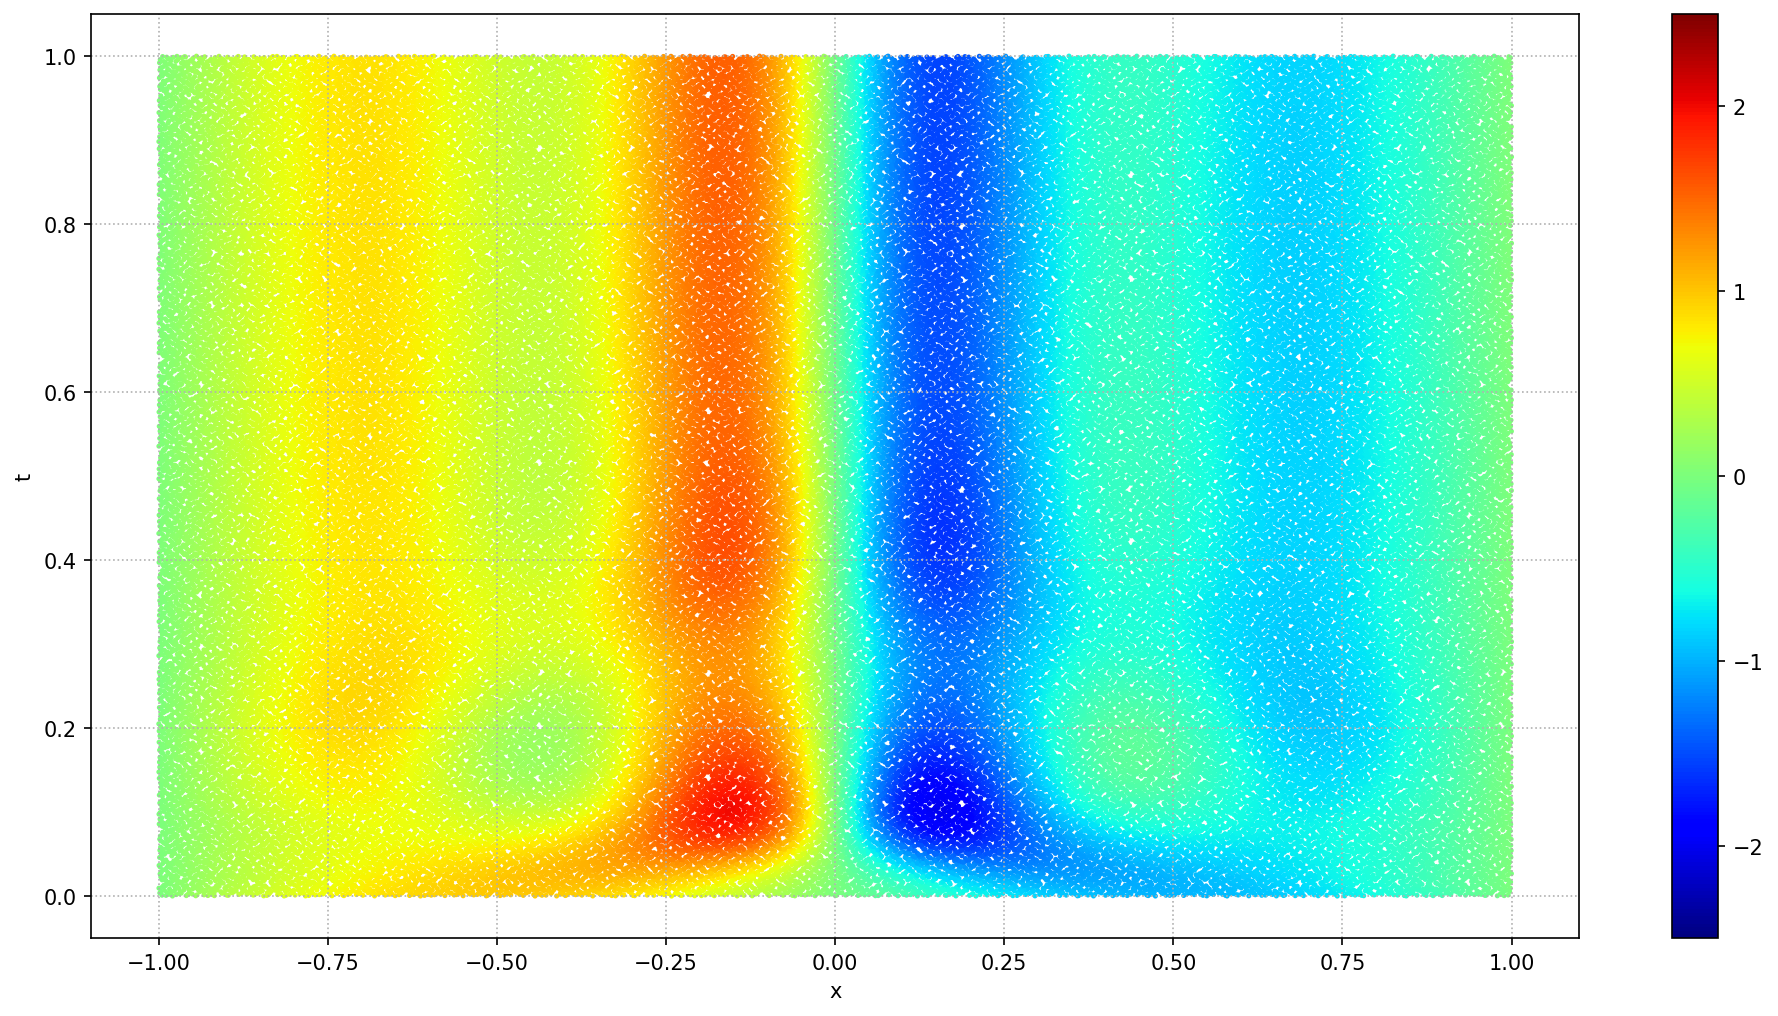

In [9]:
# Plot results with colour
def plotting():
  inputs = pinn_k.soboleng.draw(100000)
  inputs = pinn_k.convert(inputs)
  output_fluid = pinn_k.approximate_solution_flame(inputs.to(device))

  fig, axs = plt.subplots(1, 1, figsize=(16, 8), dpi=150)
  im1 = axs.scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output_fluid.cpu().detach(), cmap="jet", s=2, vmin=-2.5, vmax=2.5)
  axs.set_xlabel("x")
  axs.set_ylabel("t")
  plt.colorbar(im1, ax=axs)
  axs.grid(True, which="both", ls=":")
  #axs.set_title("Flame Front")
  plt.show()

plotting()

In [ ]:
# Reference Solutions
data = scipy.io.loadmat('/content/drive/MyDrive/ks_simple.mat')
outputs_ref = data['usol']
t = data['t'][0]
x = data['x'][0]
tt, xx = np.meshgrid(t, x)
inputs_ref = np.vstack((np.ravel(tt), np.ravel(xx))).T

# Define Plotting Function
def plotting_compare(pinn):
    inputs_pinn = torch.from_numpy(inputs_ref).to(torch.float32).to(device)
    outputs_pinn = pinn_k.approximate_solution_flame(inputs_pinn).cpu().reshape(512, 251)
    difference = torch.abs(outputs_pinn-torch.from_numpy(outputs_ref).to(torch.float32))
    #vmin = outputs_ref.min()
    #vmax = outputs_ref.max()


    fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)

    im1 = axs[0].scatter(inputs_ref[:,1], inputs_ref[:,0], c=outputs_pinn.detach(), cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    axs[0].set_title("Temp Fluid Predicted")

    im2 = axs[1].scatter(inputs_ref[:, 1], inputs_ref[:, 0], c=outputs_ref, cmap="jet", s=10 )#vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[1].set_title("Temp Fluid Reference")

    plt.show()

    fig2, ax3 = plt.subplots(figsize=(8, 6), dpi=150)
    im3 = ax3.scatter(inputs_ref[:, 1], inputs_ref[:, 0], c=difference.detach(), cmap="jet", s=10)
    ax3.set_xlabel("x")
    ax3.set_ylabel("t")
    plt.colorbar(im3, ax=ax3)
    ax3.grid(True, which="both", ls=":")

    ax3.set_title("Difference Plot")

    plt.show()



plotting_compare(pinn_k)